In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import pickle
from pprint import pprint as pp
from tqdm import tqdm
# BASE_PATH = '/content/drive/MyDrive/Generative_ML/current_data/' #@param {type:"string"}
BASE_PATH = '/Users/morgunov/batista/Summer/pipeline/'
PICKLES = BASE_PATH + 'pickles/'
INFERENCES = BASE_PATH + 'inferences/'
CHKPTS = BASE_PATH + 'checkpoints/'

# Dataset statistics

## Convert each dictionary to a dataframe

In [3]:
def split_the_dictionary(fname):
    with open(PICKLES+f'{fname}.pkl', 'rb') as f:
        smiles_to_descriptors = pickle.load(f)
    smiles = list(smiles_to_descriptors.keys())
    half_index = int(len(smiles)//2)
    pt1 = {}
    pt2 = {}
    for i, smile in enumerate(smiles):
        if i < half_index:
            pt1[smile] = smiles_to_descriptors[smile]
        else:
            pt2[smile] = smiles_to_descriptors[smile]
    print(len(pt1), len(pt2), len(pt1)+len(pt2), len(smiles_to_descriptors))
    pickle.dump(pt1, open(PICKLES + f'{fname}_subpt1.pkl', 'wb'))
    pickle.dump(pt2, open(PICKLES + f'{fname}_subpt2.pkl', 'wb'))

In [ ]:
split_the_dictionary('smile_to_descriptors_pt1')

In [ ]:
def pickle_to_csv(fname):
    with open(PICKLES+f'{fname}.pkl', 'rb') as f:
        smiles_to_descriptors = pickle.load(f)
    keyToData = {}
    keys = pickle.load(open(PICKLES + 'descriptors_list.pkl', 'rb'))
    pbar = tqdm(smiles_to_descriptors.items(), total=len(smiles_to_descriptors), desc=fname)
    for smile, descriptors in pbar:
        keyToData.setdefault('smile', []).append(smile)
        for key in keys:
            keyToData.setdefault(key, []).append(descriptors[key])
    df = pd.DataFrame(keyToData)
    df.to_pickle(PICKLES + '_'.join(fname.split('_')[2:]) + '.pkl')
    return df


In [ ]:
df = pickle_to_csv('smile_to_descriptors_pt1_subpt1') # done

In [ ]:
df = pickle_to_csv('smile_to_descriptors_pt1_subpt2') # done

In [ ]:
df = pickle_to_csv('smile_to_descriptors_pt2_subpt1') # done

In [ ]:
df = pickle_to_csv('smile_to_descriptors_pt2_subpt2')

In [ ]:
df = pickle_to_csv('smile_to_descriptors_pt3') # done

## Combine dataframes

In [ ]:
pt1_sbpt1 = pd.read_pickle(PICKLES + 'descriptors_pt1_subpt1.pkl')
pt1_sbpt2 = pd.read_pickle(PICKLES + 'descriptors_pt1_subpt2.pkl')
pt2_sbpt1 = pd.read_pickle(PICKLES + 'descriptors_pt2_subpt1.pkl')
pt2_sbpt2 = pd.read_pickle(PICKLES + 'descriptors_pt2_subpt2.pkl')
pt3 = pd.read_pickle(PICKLES + 'descriptors_pt3.pkl')
pt1_sbpt1.shape, pt1_sbpt2.shape, pt2_sbpt1.shape, pt2_sbpt2.shape, pt3.shape

In [ ]:
merged_df = pd.concat([pt1_sbpt1, pt1_sbpt2, pt2_sbpt1, pt2_sbpt2, pt3])
merged_df.shape
merged_df.to_pickle(PICKLES + 'descriptors_combined.pkl')

In [ ]:
descriptors_wsmiles = pd.read_pickle(PICKLES + 'descriptors_combined.pkl')
train_df = pd.read_csv(BASE_PATH + 'raw_data/processed_train.csv')
val_df = pd.read_csv(BASE_PATH + 'raw_data/processed_val.csv')
# Create boolean series for whether 'smile' column is in each dataframe
is_in_train_df = descriptors_wsmiles['smile'].isin(train_df['smiles'])
is_in_val_df = descriptors_wsmiles['smile'].isin(val_df['smiles'])

# Combine the two series with logical or (|)
is_in_either_df = is_in_train_df | is_in_val_df

# Select only rows where 'smile' column is in either dataframe
descriptors_wsmiles_excluded = descriptors_wsmiles[is_in_either_df]

descriptors_wsmiles_excluded.to_pickle(PICKLES + 'descriptors_combined_processed.pkl')

val = 285448 + 1
train = 5423523 + 1
total = val + train
print(total, descriptors_wsmiles.shape, descriptors_wsmiles_excluded.shape)
# 5708973 (5770637, 210) (5708842, 210) apparently more invalid smiles?

In [6]:
descriptors_wsmiles = pd.read_pickle(PICKLES + 'descriptors_combined.pkl')
print(descriptors_wsmiles.shape)
train_df = pd.read_csv(BASE_PATH + 'raw_data/moses_and_binding_no_rare_tokens_train.csv.gz', compression='gzip')
test_df = pd.read_csv(BASE_PATH + 'raw_data/moses_and_binding_no_rare_tokens_test.csv.gz', compression='gzip')
# Create boolean series for whether 'smile' column is in each dataframe
is_in_train_df = descriptors_wsmiles['smile'].isin(train_df['smiles'])
is_in_test_df = descriptors_wsmiles['smile'].isin(test_df['smiles'])

# Combine the two series with logical or (|)
is_in_either_df = is_in_train_df | is_in_test_df

# Select only rows where 'smile' column is in either dataframe
descriptors_wsmiles_excluded = descriptors_wsmiles[is_in_either_df]
print(descriptors_wsmiles_excluded.shape)
descriptors_wsmiles_excluded.to_pickle(PICKLES + 'descriptors_moses+bindingdb.pkl')

val = 285448 + 1
train = 5423523 + 1
total = val + train
# print(total, descriptors_wsmiles.shape, descriptors_wsmiles_excluded.shape)
# 5708973 (5770637, 210) (5708842, 210) apparently more invalid smiles?

(5770637, 210)
(2894910, 210)


# PCA Analysis

## Definitions

In [2]:
class Graph:
    def __init__(self):
        self.title_size = 20
        self.axis_title_size = 14
        self.tick_font_size = 12
        self.text_color="#333333"
        self.background = "white"
        self.grid_color = "#e2e2e2"
        self.line_color = "#000000"
        self.font_family = 'Helvetica'
        self.width = 600
        self.height = 400
        self.title = ''
        self.xaxis_title = ''
        self.yaxis_title = ''

    def update_parameters(self, params):
        for key, val in params.items():
            setattr(self, key, val)


    def style_figure(self, figure):
        figure.update_layout({
            'margin': {'t': 50, 'b': 50, 'l': 50, 'r': 50},
            'plot_bgcolor': self.background,
            'paper_bgcolor': self.background,
            'title': {
                'text': self.title,
                'font': {
                    'size': self.title_size,
                    'color': self.text_color,
                    'family': self.font_family
                },
            },
            'height': self.height,  # Set fixed size ratio 3:4
            'width': self.width,
            'font': {
                'family': self.font_family,
                'size': self.tick_font_size,
                'color': self.text_color
            },
            'legend': {
                'font': {
                    'family': self.font_family,
                    'size': self.tick_font_size,
                    'color': self.text_color
                },
            },
        })

        # Setting the title size and color and grid for both x and y axes
        figure.update_xaxes(
            title=self.xaxis_title,
            title_font={'size': self.axis_title_size, 'color': self.text_color, 'family': self.font_family},
            tickfont={'size': self.tick_font_size, 'color': self.text_color, 'family': self.font_family},
            showgrid=True,
            gridwidth=1,
            gridcolor=self.grid_color,
            linecolor=self.line_color,  # make x axis line visible
            linewidth=2
        )

        figure.update_yaxes(
            title=self.yaxis_title,
            title_standoff=0,
            title_font={'size': self.axis_title_size, 'color': self.text_color, 'family': self.font_family},
            tickfont={'size': self.tick_font_size, 'color': self.text_color, 'family': self.font_family},
            showgrid=True,
            gridwidth=1,
            gridcolor=self.grid_color,
            linecolor=self.line_color,  # make y axis line visible
            linewidth=2
        )
        return figure

In [26]:
def fit_pca(dataframe, n=3, sigma=None, whiten=False):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataframe)
    if sigma is not None:
        scaled_data = scaled_data[(scaled_data <= sigma).all(axis=1)]
    pca = PCA(n_components=n, whiten=whiten)
    pca.fit(scaled_data)
    return scaler, pca

def pca_transform(pca, dataframe, n):
    assert pca.n_components_ >= n, f"PCA was fitted on {pca.n_components_} components, but {n} were requested."
    transformed = pca.transform(dataframe)
    return [transformed[:,i] for i in range(n)]

def create_scatter_trace(x, y, color, name):
    return go.Scatter(x=x, y=y, mode='markers', name=name,
                      marker=dict(size=5, color=color, opacity=0.5)
            )

def create_scatter3d_trace(x, y, z, color, name):
    return go.Scatter3d(x=x, y=y, z=z, mode='markers', name=name,
                      marker=dict(size=5, color=color, opacity=0.5)
            )

def plot_pca(datapoints, yscale=1.05):
    fig = go.Figure()
    minX, minY, maxX, maxY = float('inf'), float('inf'), float('-inf'), float('-inf')
    traces = []
    for xarr, yarr, color, label in datapoints:
        minX = min(minX, min(xarr))
        minY = min(minY, min(yarr))
        maxX = max(maxX, max(xarr))
        maxY = max(maxY, max(yarr))
        traces.append(create_scatter_trace(xarr, yarr, color, label))

    for trace in traces:
        fig.add_trace(trace)

    fig.update_layout(
        xaxis=dict(title='PCA Component 1', autorange=False, range=[yscale*minX,  yscale*maxX]),
        yaxis=dict(title='PCA Component 2', autorange=False, range=[yscale*minY, yscale*maxY]),
    )
    return fig

def plot_pca_3d(datapoints, yscale=1.05):
    fig = go.Figure()
    minX, minY, minZ, maxX, maxY, maxZ = float('inf'), float('inf'), float('inf'), float('-inf'), float('-inf'), float('-inf')
    traces = []
    for xarr, yarr, zarr, color, label in datapoints:
        minX = min(minX, min(xarr))
        minY = min(minY, min(yarr))
        maxX = max(maxX, max(xarr))
        maxY = max(maxY, max(yarr))
        minZ = min(minZ, min(zarr))
        maxZ = max(maxZ, max(zarr))
        traces.append(create_scatter3d_trace(xarr, yarr, zarr, color, label))

    for trace in traces:
        fig.add_trace(trace)

    fig.update_layout(
        scene=dict(
            xaxis=dict(title='PCA Component 1', autorange=False, range=[yscale*minX, yscale*maxX]),
            yaxis=dict(title='PCA Component 2', autorange=False, range=[yscale*minY, yscale*maxY]),
            zaxis=dict(title='PCA Component 3', autorange=False, range=[yscale*minZ, yscale*maxZ]),
        )
    )
    return fig

## Fitting

In [5]:
descriptors = pd.read_pickle(PICKLES + 'descriptors_moses+bindingdb.pkl')
blacklist = ['smile', 'Ipc', 'AvgIpc', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'MaxAbsPartialCharge', 'MaxPartialCharge', 'MinAbsPartialCharge', 'MinPartialCharge']
descriptors = descriptors.drop(columns=blacklist)
descriptors.shape

(2894910, 195)

In [6]:
scaler, pca = fit_pca(descriptors, n=100)
pickle.dump((scaler, pca), open(PICKLES + 'scaler_pca_moses+bingingdb.pkl', 'wb'))

In [14]:
scaler, pca = pickle.load(open(PICKLES + 'scaler_pca_moses+bindingdb.pkl', 'rb'))
# gptMols = pd.read_pickle(PICKLES + 'gptMols.pickle')
# bindingdb = pd.read_pickle(PICKLES + 'unique_bindingdb.pickle')
gptNew = pd.read_pickle(INFERENCES + 'GPT_pretrain_inference_07_14_23_39_1end_ignore_moses+bindingdb_temp1.0_descriptors.pkl')
gptNew_smiles = pd.read_csv(INFERENCES + 'GPT_pretrain_inference_07_14_23_39_1end_ignore_moses+bindingdb_temp1.0_processed.csv')
columns = pickle.load(open(PICKLES + 'descriptors_moses+bindingdb_columnlist.pkl', 'rb'))

In [12]:
sampled_uniform = gptNew[gptNew_smiles['smiles'].isin(pd.read_csv(INFERENCES + 'samples_uniform.csv')['smiles'])]
sampled_probabilistic = gptNew[gptNew_smiles['smiles'].isin(pd.read_csv(INFERENCES + 'samples_probabilistic.csv')['smiles'])]
sampled_percentiles_2 = gptNew[gptNew_smiles['smiles'].isin(pd.read_csv(INFERENCES + 'samples_percentiles_2.csv')['smiles'])]
sampled_percentiles_3 = gptNew[gptNew_smiles['smiles'].isin(pd.read_csv(INFERENCES + 'samples_percentiles_3.csv')['smiles'])]
sampled_percentiles_4 = gptNew[gptNew_smiles['smiles'].isin(pd.read_csv(INFERENCES + 'samples_percentiles_4.csv')['smiles'])]

In [19]:
sample = 1_000
plot_pca(
    [
    #  (*pca_transform(pca, scaler.transform(bindingdb[descriptors.columns].sample(n=sample, random_state=1337)), n=2), '#A4A9AD', f'BindingDB'),
    #  (*pca_transform(pca, scaler.transform(descriptors.sample(n=sample, random_state=1337)), n=2), '#2E86AB', f'MOSES + BindingDB(processed)'),
     (*pca_transform(pca, scaler.transform(gptNew[columns].sample(n=sample, random_state=1337)), n=2), '#343a40', f'GPT new 10k'),
    (*pca_transform(pca, scaler.transform(sampled_uniform[columns]), n=2), '#390099', f'Uniform'),
    (*pca_transform(pca, scaler.transform(sampled_probabilistic[columns]), n=2), '#9e0059', f'Probabilistic'),
    (*pca_transform(pca, scaler.transform(sampled_percentiles_2[columns]), n=2), '#004b23', f'50th percentile'),
    (*pca_transform(pca, scaler.transform(sampled_percentiles_3[columns]), n=2), '#669bbc', f'33rd, 66th percentile'),
    (*pca_transform(pca, scaler.transform(sampled_percentiles_4[columns]), n=2), '#7f4f24', f'25, 50, 75'),

    # (*pca_transform(pca, scaler.transform(gptNew[descriptors.columns].sample(n=5_00, random_state=1337)), n=2), '#FFBA08', f'GPT new 500'),
    #  (*pca_transform(pca, scaler.transform(gptMols[descriptors.columns].sample(n=sample, random_state=1337)), n=2), '#20063B', f'GPT old'),
    ], yscale=1.5
).show()

In [27]:
sample = 1_000
n_dim = 3
plot_pca_3d(
    [
     (*pca_transform(pca, scaler.transform(gptNew[columns].sample(n=sample, random_state=1337)), n=n_dim), '#343a40', f'GPT new 10k'),
    (*pca_transform(pca, scaler.transform(sampled_uniform[columns]), n=n_dim), '#390099', f'Uniform'),
    (*pca_transform(pca, scaler.transform(sampled_probabilistic[columns]), n=n_dim), '#9e0059', f'Probabilistic'),
    (*pca_transform(pca, scaler.transform(sampled_percentiles_2[columns]), n=n_dim), '#004b23', f'50th percentile'),
    (*pca_transform(pca, scaler.transform(sampled_percentiles_3[columns]), n=n_dim), '#669bbc', f'33rd, 66th percentile'),
    (*pca_transform(pca, scaler.transform(sampled_percentiles_4[columns]), n=n_dim), '#7f4f24', f'25, 50, 75'),
    ], yscale=1.5
).show()

0.9798377684690455
0.23719436755098017


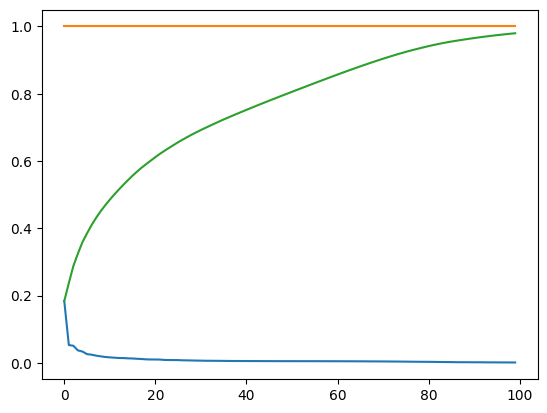

In [32]:
import matplotlib.pyplot as plt

var_arr = pca.explained_variance_ratio_
print(sum(var_arr))
print(sum(var_arr[:2]))
cum_varr = np.cumsum(var_arr)
plt.plot(var_arr)
plt.plot([1 for _ in range(len(var_arr))])
plt.plot(cum_varr)